# 1 Monte-Carlo Simulation

## 1.1 Data Creation and Visualization

In [65]:
from typing import Tuple, List, Set

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")


### Create the inverse Distributions

#### Case Y = 0

$ P(X = x | Y = 0) = 2 - 2x $

$ => P (X \leq x | Y = 0) = 2x - x^2 $

Therefore we find the inverse by quadratic completion:
$F_{X, Y = 0}^{-1}(u) = 1 - \sqrt{1 - u}$


#### Case Y = 1

$ P(X = x | Y = 1) = 2 - 2x $

$ => P (X \leq x | Y = 0) = 2x - x^2 $

Therefore we find the inverse by quadratic completion:
$F_{X, Y = 1}^{-1}(u) = \sqrt{u}$

For the data generation, we generate uniformly create the label

For sampling the features $x$ later, we already create the uniform distributed floats in $[0,1]$

Then we fill in the feature vector
We decide which inverse we use with the label and use the corresponding $u$

At the end the sampled values are returned

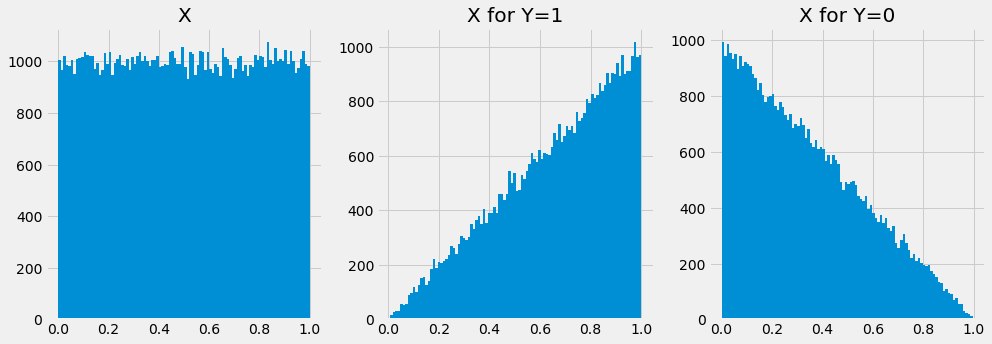

In [66]:
def create_data(N: int) -> Tuple[np.ndarray, np.ndarray]:
    label_y = np.random.randint(2, size=N)  # prior probability = 1/2
    u = np.random.uniform(0, 1, size=N)
    feature_x = np.array([np.sqrt(_u) if y==1 else 1 - np.sqrt(1-_u) for _u, y in zip(u, label_y)])
    return feature_x, label_y

    
_datax, _datay = create_data(100000)

fig: plt.Figure
ax: List[plt.Axes]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

_ = ax[0].hist(_datax, bins=100)
_ = ax[0].set_title("X")
_ = ax[1].hist([x for x, y in zip(_datax, _datay) if y==1], bins=100)
_ = ax[1].set_title("X for Y=1")
_ = ax[2].hist([x for x, y in zip(_datax, _datay) if y==0], bins=100)
_ = ax[2].set_title("X for Y=0")




## 1.2 Classification by Tresholding

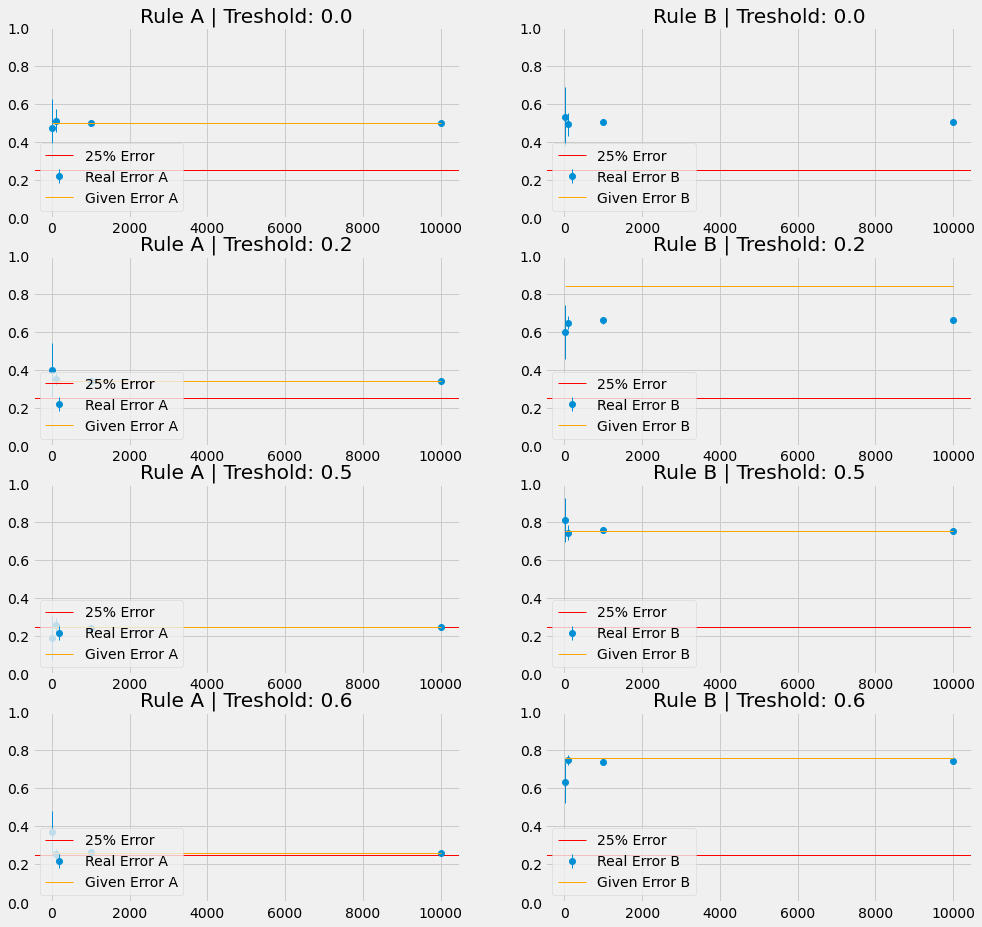

In [67]:
def rule_a(features_x: np.ndarray, x_treshold: float) -> np.ndarray:
    return np.array([0 if x < x_treshold else 1 for x in features_x])

def rule_b(features_x: np.ndarray, x_treshold: float) -> np.ndarray:
    return np.array([1 if x < x_treshold else 0 for x in features_x])

def error_prob_rule_a(x_treshold: float) -> float:
    return 0.25 + (x_treshold - 0.5)**2

def error_prob_rule_b(x_treshold: float) -> float:
    return 0.75 + (x_treshold - 0.5)**2

x_t: List[float] = [0.0, 0.2, 0.5, 0.6]
M: List[int] = [10, 100, 1000, 10000]

fig: plt.Figure
ax: List[List[plt.Axes]]
fig, ax = plt.subplots(len(x_t), 2, figsize=(15, 15))

error_a: float = 0.0
error_b: float = 0.0
for ax_i, treshold in enumerate(x_t):
    plot_a: List[Tuple[int, float]] = []
    plot_b: List[Tuple[int, float]] = []
    error_func_a: List[Tuple[int, float]] = []
    error_func_b: List[Tuple[int, float]] = []


    std_a: List[float] = []
    std_b: List[float] = []
    for m in M:
        std_me_a: List[float] = [] 
        std_me_b: List[float] = [] 
        error_a = 0.0  # reset our errors for earch 10 runs
        error_b = 0.0
        for i in range(10):
            # Create Test Data
            x, y = create_data(m)
            
            # RuleA
            rule_y = rule_a(x, treshold)
            diff: np.ndarray = (y+rule_y)  # if matched, then either 0+0 or 1+1, so error is 1
            err_a = np.count_nonzero(diff==1)/len(diff)
            error_a += err_a
            std_me_a.append(err_a)
            
            # RuleB
            rule_y = rule_b(x, treshold)
            diff: np.ndarray = (y+rule_y)
            err_b = np.count_nonzero(diff==1)/len(diff)
            error_b += err_b
            std_me_b.append(err_b)
        error_a /= 10  # divide our sum of errors by the amount of runs
        error_b /= 10  

        std_a.append(np.std(std_me_a))
        std_b.append(np.std(std_me_b))


        plot_a.append((m, error_a))
        plot_b.append((m, error_b))

        error_func_a.append((m, error_prob_rule_a(treshold)))
        error_func_b.append((m, error_prob_rule_b(treshold)))

    # Plot Error A
    ax[ax_i][0].errorbar(*zip(*plot_a), std_a, marker="o", linestyle="None", linewidth=1, label="Real Error A")
    ax[ax_i][0].errorbar(*zip(*error_func_a), color="orange", linewidth=1, label="Given Error A")
    ax[ax_i][0].set_title(f"Rule A | Treshold: {treshold}")
    ax[ax_i][0].axhline(0.25, color="red", linewidth=1, label="25% Error")
    ax[ax_i][0].set_ybound(0, 1)
    ax[ax_i][0].legend(loc="lower left")

    # Plot Error B
    ax[ax_i][1].errorbar(*zip(*plot_b), std_b, marker="o", linestyle="None", linewidth=1, label="Real Error B")
    ax[ax_i][1].errorbar(*zip(*error_func_b), color="orange", linewidth=1, label="Given Error B")
    ax[ax_i][1].set_title(f"Rule B | Treshold: {treshold}")
    ax[ax_i][1].axhline(0.25, color="red", linewidth=1, label="25% Error")
    ax[ax_i][1].set_ybound(0, 1)
    ax[ax_i][1].legend(loc="lower left")





        




The standard deviation decreases, because the testset sizes are bigger and the mean converges there more than in a smaller test set (law of big numbers).
So we are closer to the real error rate and hence have less deviation between the runs.

## 1.3 Baseline Classifiers

In [68]:
def rule_c(features_x: np.ndarray) -> np.ndarray:
    return np.random.randint(0, 2, size=features_x.size)

def rule_d(features_x: np.ndarray) -> np.ndarray:
    return np.ones(features_x.size)    

now plot them the exact same way as before...

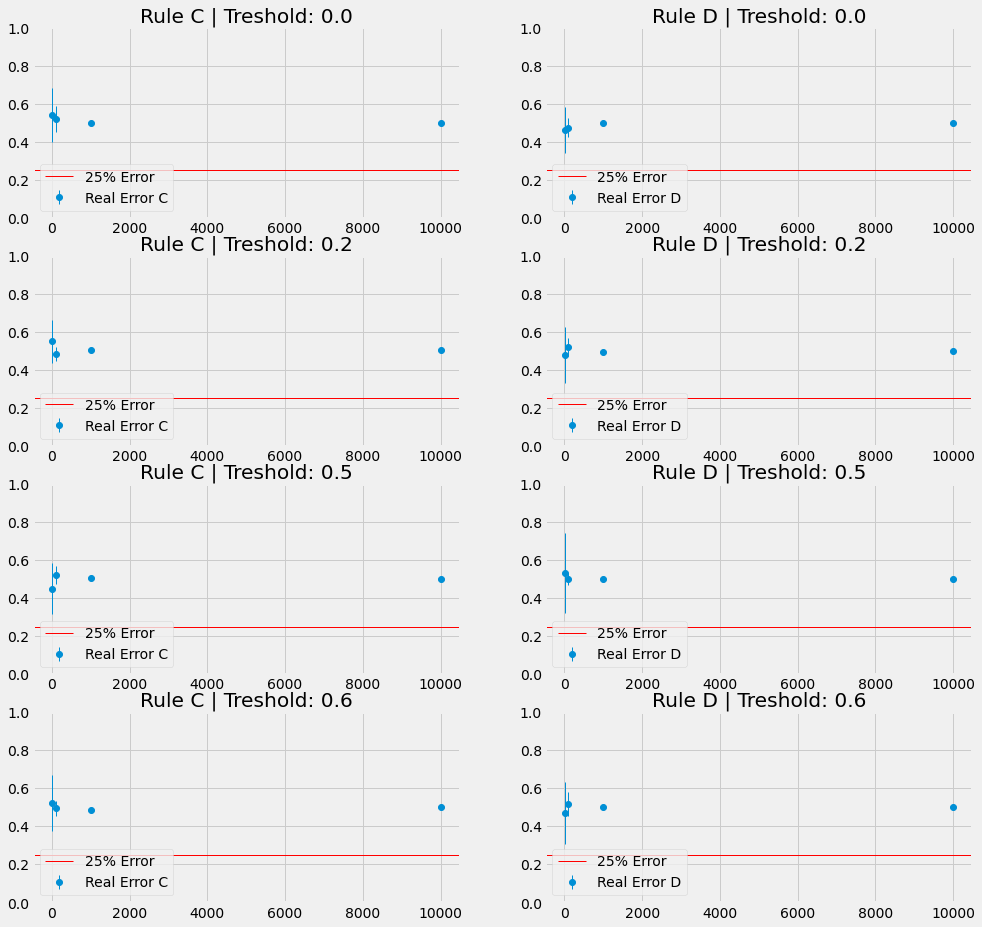

In [69]:
x_t: List[float] = [0.0, 0.2, 0.5, 0.6]
M: List[int] = [10, 100, 1000, 10000]

fig: plt.Figure
ax: List[List[plt.Axes]]
fig, ax = plt.subplots(len(x_t), 2, figsize=(15, 15))

error_c: float = 0.0
error_d: float = 0.0
for ax_i, treshold in enumerate(x_t):
    plot_c: List[Tuple[int, float]] = []
    plot_d: List[Tuple[int, float]] = []

    std_c: List[float] = []
    std_d: List[float] = []
    for m in M:
        std_me_c: List[float] = [] 
        std_me_d: List[float] = [] 
        error_c = 0.0  # reset our errors for earch 10 runs
        error_d = 0.0
        for i in range(10):
            # Create Test Data
            x, y = create_data(m)
            
            # RuleC
            rule_y = rule_c(x)
            diff: np.ndarray = (y+rule_y)  # if matched, then either 0+0 or 1+1, so error is 1
            err_c = np.count_nonzero(diff==1)/len(diff)
            error_c += err_c
            std_me_c.append(err_c)
            
            # RuleD
            rule_y = rule_d(x)
            diff: np.ndarray = (y+rule_y)
            err_d = np.count_nonzero(diff==1)/len(diff)
            error_d += err_d
            std_me_d.append(err_d)
        error_c /= 10  # divide our sum of errors by the amount of runs
        error_d /= 10  

        std_c.append(np.std(std_me_c))
        std_d.append(np.std(std_me_d))


        plot_c.append((m, error_c))
        plot_d.append((m, error_d))


    # Plot Error A
    ax[ax_i][0].errorbar(*zip(*plot_c), std_c, marker="o", linestyle="None", linewidth=1, label="Real Error C")
    ax[ax_i][0].set_title(f"Rule C | Treshold: {treshold}")
    ax[ax_i][0].axhline(0.25, color="red", linewidth=1, label="25% Error")
    ax[ax_i][0].set_ybound(0, 1)
    ax[ax_i][0].legend(loc="lower left")

    # Plot Error B
    ax[ax_i][1].errorbar(*zip(*plot_d), std_d, marker="o", linestyle="None", linewidth=1, label="Real Error D")
    ax[ax_i][1].set_title(f"Rule D | Treshold: {treshold}")
    ax[ax_i][1].axhline(0.25, color="red", linewidth=1, label="25% Error")
    ax[ax_i][1].set_ybound(0, 1)
    ax[ax_i][1].legend(loc="lower left")

## 1.4 Nearest Neighbor Classification

In [70]:
def toy_nearest_neighbor(XTest: np.ndarray, Xtrain: np.ndarray, YTrain: np.ndarray) -> np.ndarray:
    ...